# [Homework 3](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week03.pdf)

In [31]:
import jax.numpy as np
import pandas as pd
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi, print_summary
import numpyro.distributions as dist
import arviz as az
from plotnine import *
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
rng_key = random.PRNGKey(0)
theme_set( theme_seaborn(style='darkgrid'))
%config InlineBackend.figure_format ='retina'


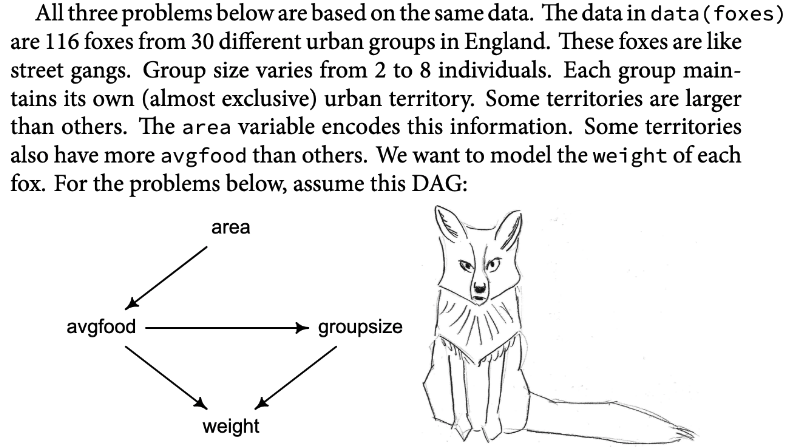
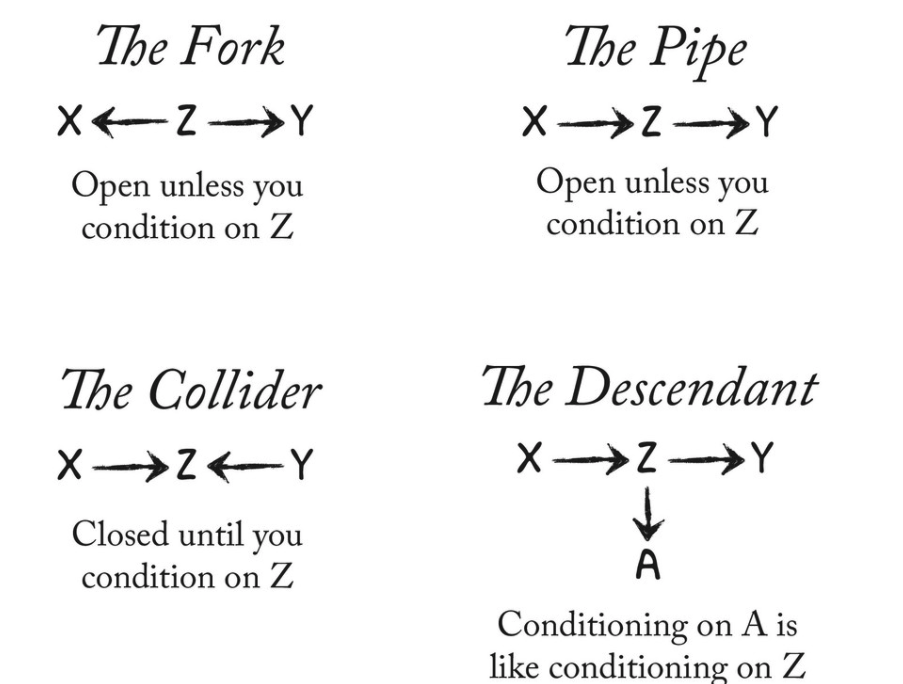


In [24]:
df_data = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/foxes.csv', delimiter=';')
## standardize the variables we need to standardize only continous variables
df_data[['avgfood', 'groupsize', 'area', 'weight']] = (df_data[['avgfood', 'groupsize', 'area', 'weight']] - df_data[['avgfood', 'groupsize', 'area', 'weight']].mean())/df_data[['avgfood', 'groupsize', 'area', 'weight']].std()
print(df_data.describe())
print(df_data.head())

            group       avgfood     groupsize          area        weight
count  116.000000  1.160000e+02  1.160000e+02  1.160000e+02  1.160000e+02
mean    17.206897  3.024401e-16 -1.741902e-16 -6.393353e-16  4.230333e-16
std      8.002736  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min      1.000000 -1.924829e+00 -1.524089e+00 -2.239596e+00 -2.204059e+00
25%     11.750000 -4.625154e-01 -8.741098e-01 -6.238331e-01 -6.838173e-01
50%     18.000000 -8.433082e-02 -2.241307e-01 -4.215842e-02 -9.261240e-02
75%     24.000000  2.434292e-01  4.258483e-01  6.499268e-01  7.139601e-01
max     30.000000  2.310838e+00  2.375785e+00  2.047562e+00  2.550918e+00
   group   avgfood  groupsize      area    weight
0      1 -1.924829  -1.524089 -2.239596  0.414135
1      1 -1.924829  -1.524089 -2.239596 -1.427046
2      2 -1.118035  -1.524089 -1.205508  0.675954
3      2 -1.118035  -1.524089 -1.205508  1.300942
4      3 -1.319734  -1.524089 -1.130106  1.115135


### Question 1

>Use a model to infer the total causal influence of area on weight. Would increasing the area available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the possible outcome range.

No backdoor so could directly do a model as

$$\text{weight}\sim\mathcal{N}(\mu,\sigma)$$
$$\mu = \alpha + \beta*area$$

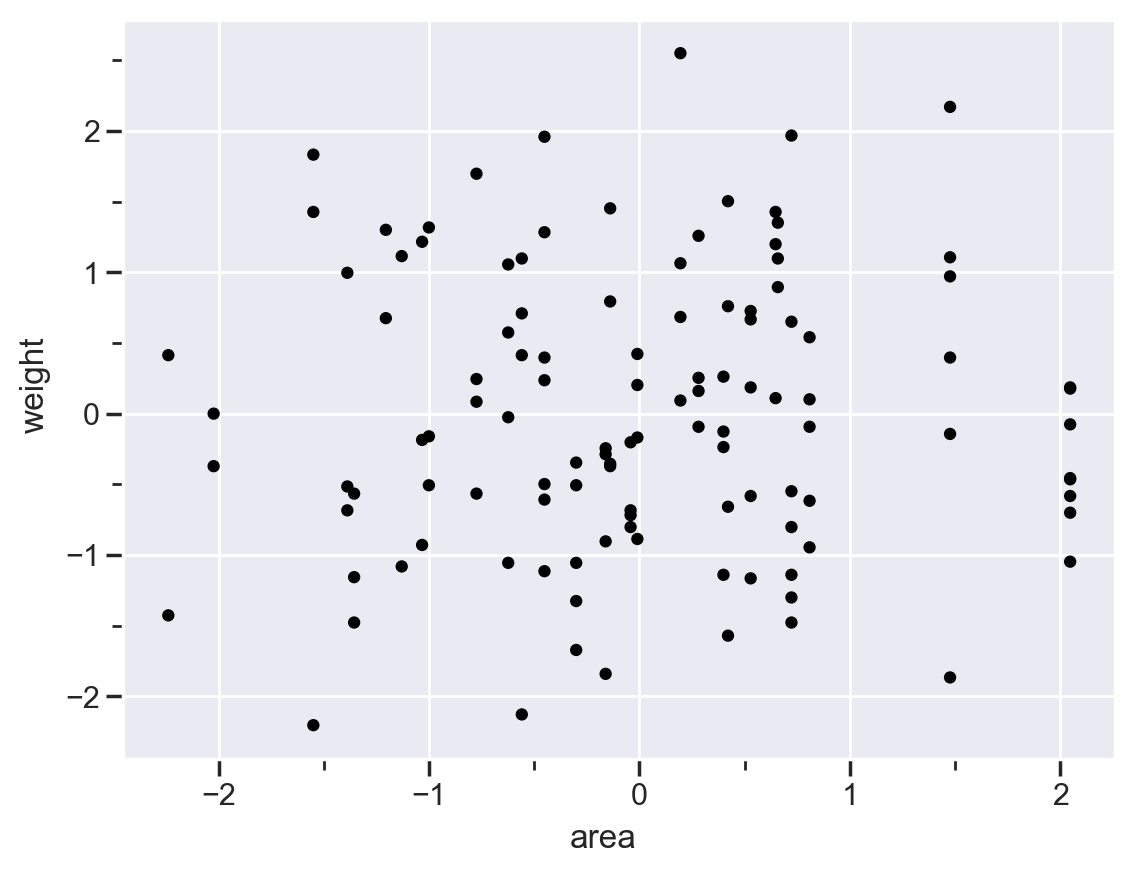

<ggplot: (8763948806259)>

In [26]:
    (
        ggplot(df_data, aes(x='area',y='weight'))+
        geom_point()
    )

In [39]:
def m1(area, weight=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0,0.5))
    beta_area = numpyro.sample('beta_area', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = numpyro.deterministic('mu', alpha + beta_area * area)
    numpyro.sample('weight_hat', dist.Normal(mu,sigma), obs=weight)

In [40]:
# Run NUTS
kernel = NUTS(m1)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000,num_chains=4,progress_bar=False)
mcmc.run(rng_key, area=df_data.area.values, weight=df_data.weight.values)
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha      0.00      0.09     -0.00     -0.14      0.14   7169.69      1.00
  beta_area      0.01      0.09      0.02     -0.13      0.15   7512.48      1.00
      sigma      1.01      0.07      1.01      0.90      1.11   7211.87      1.00

Number of divergences: 0


array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta_area'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

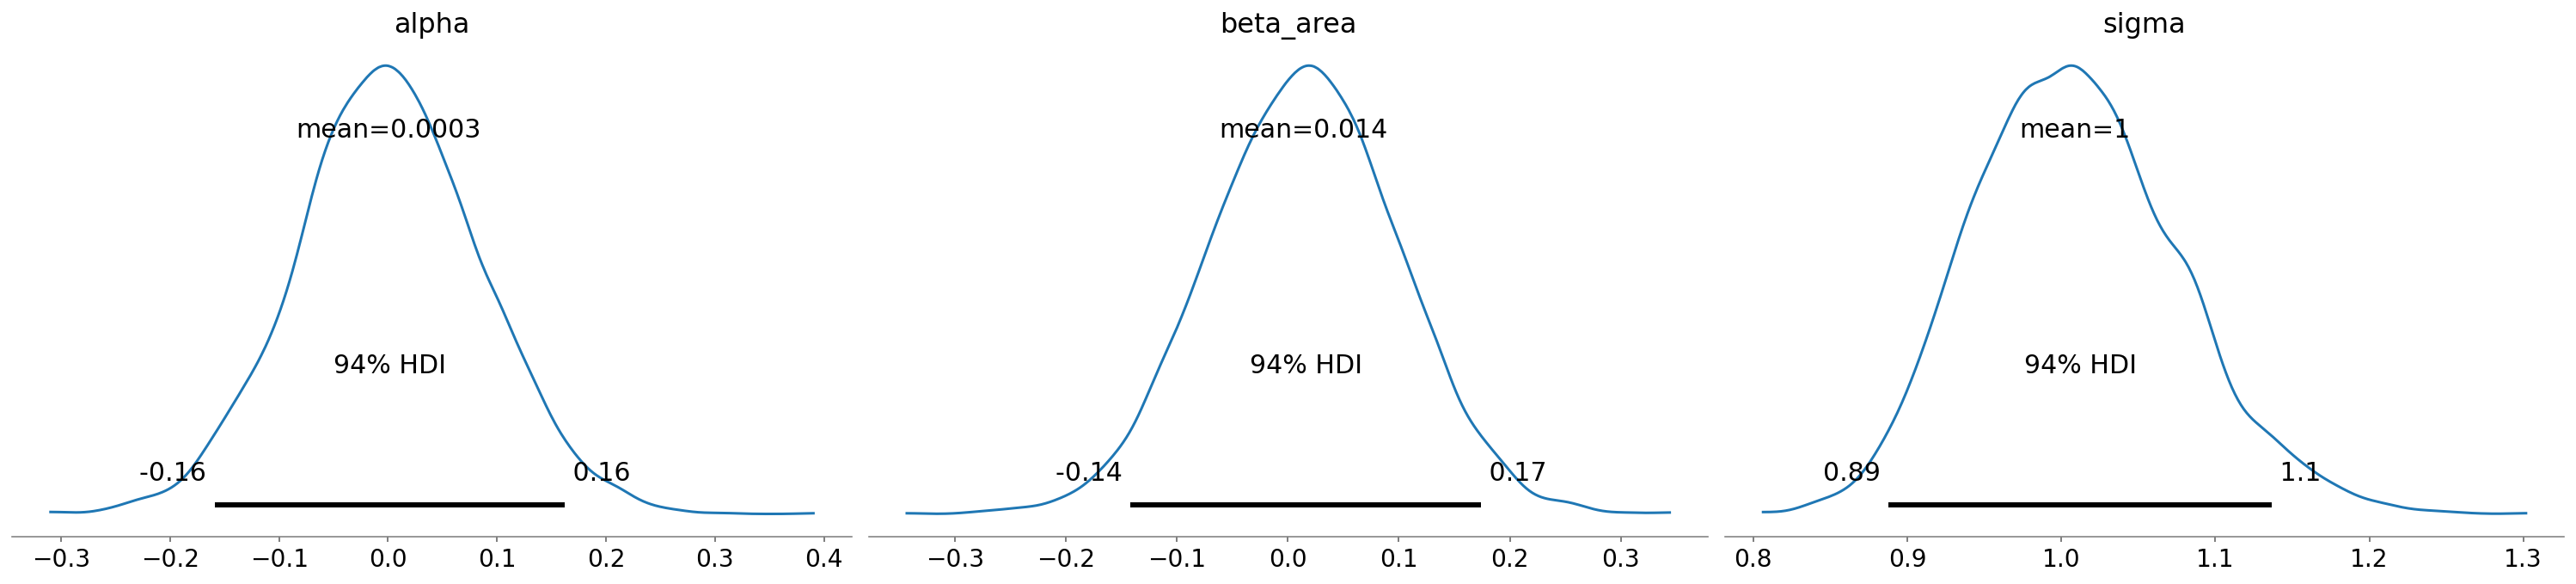

In [41]:
## just plotting for fun
inference_data = az.from_numpyro(mcmc)
az.plot_posterior(inference_data, var_names=['alpha', 'beta_area', 'sigma'])

***No total causal effect of area on weight***

### Question 2

>Now infer the causal impact of adding food (avgfood) to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

again as we need total effect of food and there exist no back door path so just do a esimple model like earlier


$$\text{weight}\sim\mathcal{N}(\mu,\sigma)$$
$$\mu = \alpha + \beta*avgfood$$

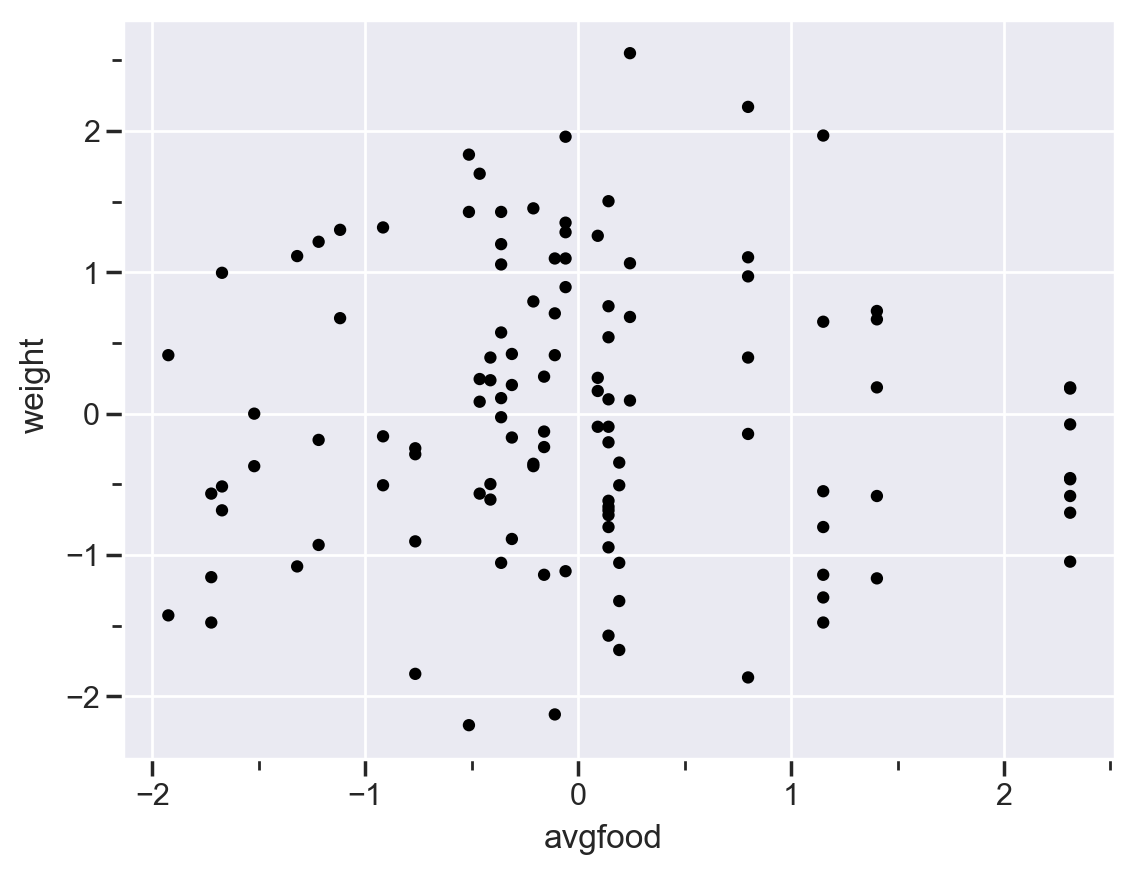

<ggplot: (8764027453453)>

In [42]:
(
    ggplot(df_data, aes(x='avgfood',y='weight'))+
    geom_point()
)

In [47]:
def m2(avgfood, weight=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0,0.5))
    beta_food = numpyro.sample('beta_food', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = numpyro.deterministic('mu', alpha + beta_food * avgfood)
    numpyro.sample('weight_hat', dist.Normal(mu,sigma), obs=weight)

In [50]:
# Run NUTS
kernel = NUTS(m2)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000,num_chains=4,progress_bar=False)
mcmc.run(rng_key, avgfood=df_data.avgfood.values, weight=df_data.weight.values)
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha      0.00      0.08     -0.00     -0.13      0.14   7735.31      1.00
  beta_food     -0.02      0.08     -0.02     -0.16      0.12   7069.16      1.00
      sigma      1.01      0.07      1.00      0.89      1.11   6740.21      1.00

Number of divergences: 0


array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta_food'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

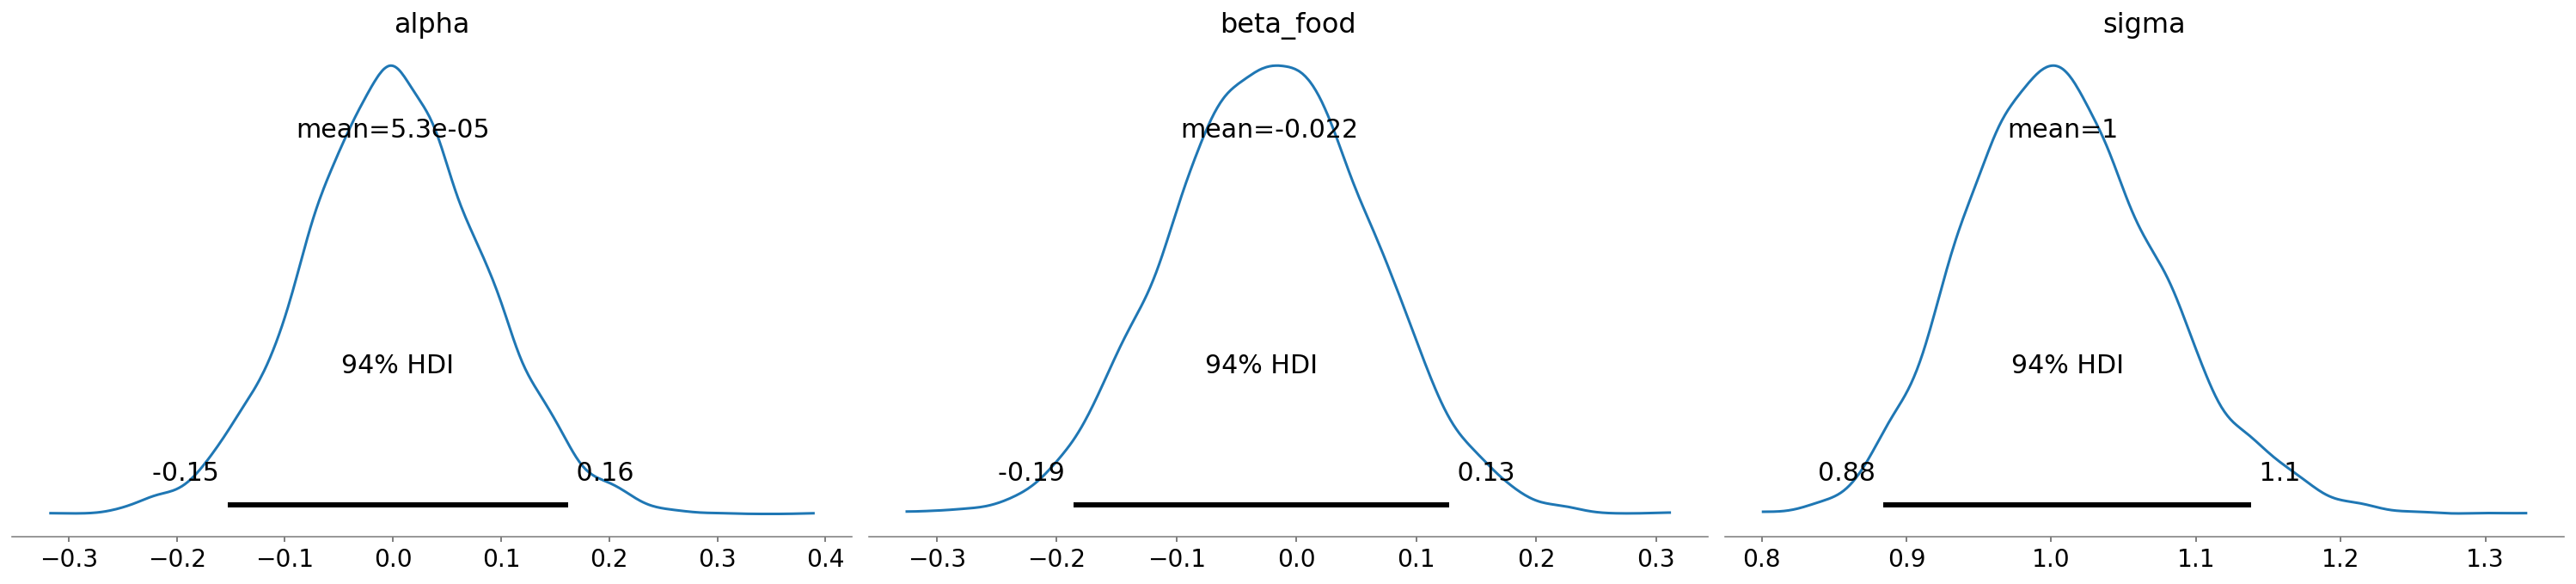

In [51]:
## just plotting for fun
inference_data = az.from_numpyro(mcmc)
az.plot_posterior(inference_data, var_names=['alpha', 'beta_food', 'sigma'])

***No total causal effect of avgfood on weight***

### Question 3

>Now infer the causal impact of group size. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they make sense together?

now for groupsize we have a backdoor of food which is fork, which we can close by conditioning on that variable so our model is 

$$\text{weight}\sim\mathcal{N}(\mu,\sigma)$$
$$\mu = \alpha + \beta_1*avgfood + \beta_2*groupsize$$

In [60]:
def m3(avgfood, groupsize, weight=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0,0.5))
    beta_food = numpyro.sample('beta_food', dist.Normal(0,0.5))
    beta_group_size = numpyro.sample('beta_group_size', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = numpyro.deterministic('mu', alpha + beta_food * avgfood + beta_group_size * groupsize)
    numpyro.sample('weight_hat', dist.Normal(mu,sigma), obs=weight)

In [61]:
# Run NUTS
kernel = NUTS(m3)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000,num_chains=4,progress_bar=False)
mcmc.run(rng_key, avgfood=df_data.avgfood.values, groupsize=df_data.groupsize.values, weight=df_data.weight.values)
mcmc.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
            alpha     -0.00      0.09     -0.00     -0.15      0.14   6097.56      1.00
        beta_food      0.47      0.19      0.47      0.18      0.78   3969.03      1.00
  beta_group_size     -0.56      0.19     -0.57     -0.87     -0.27   4056.54      1.00
            sigma      0.96      0.07      0.96      0.86      1.07   6257.59      1.00

Number of divergences: 0


array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta_food'}>,
       <AxesSubplot:title={'center':'beta_group_size'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

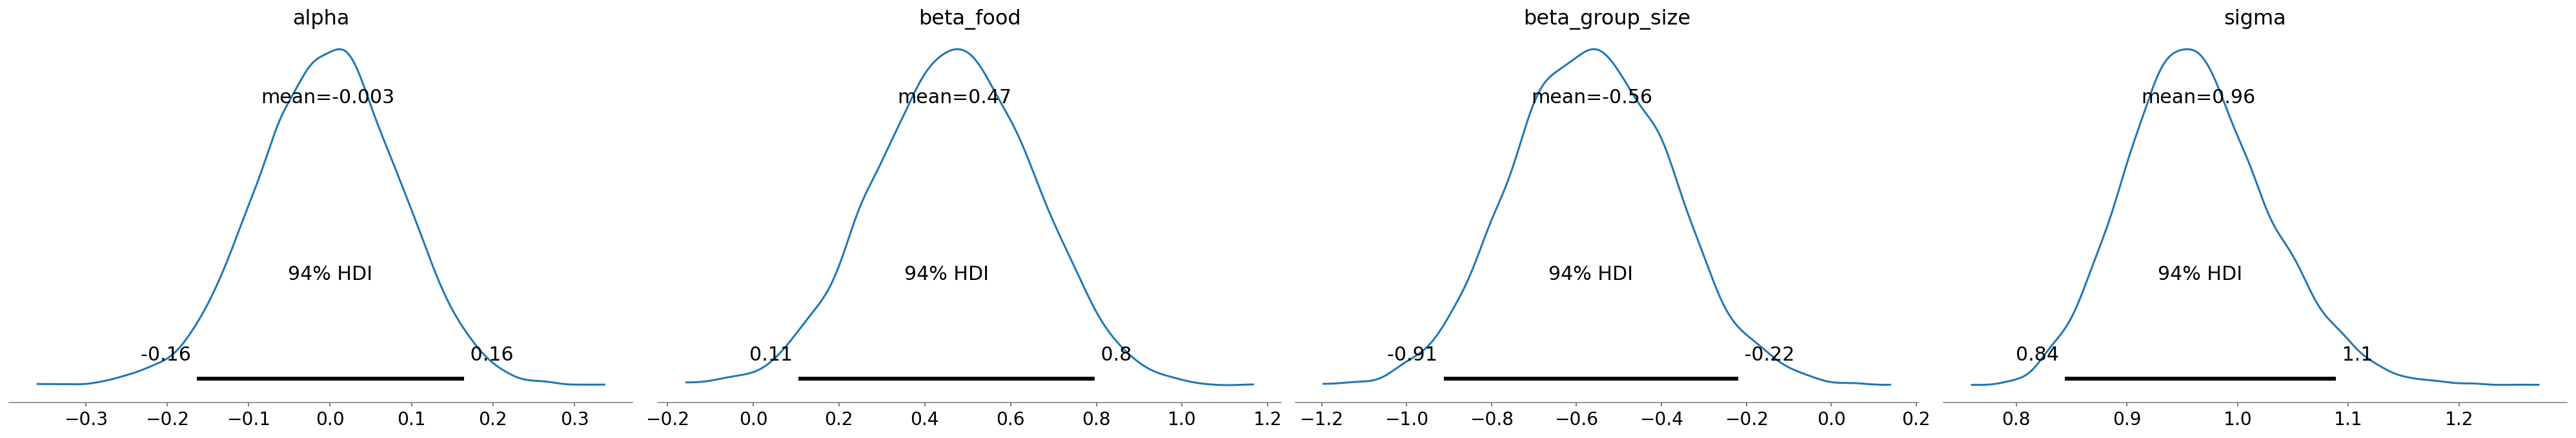

In [62]:
## just plotting for fun
inference_data = az.from_numpyro(mcmc)
az.plot_posterior(inference_data, var_names=['alpha', 'beta_food', 'beta_group_size', 'sigma'])

***This is interesting as here you see that group size has negative effect which means less food for each fox conditioned on avgfood. the effect of food here is positive, which is not total effect as in question 2. Basically food has no effect if you see dag because, with increase in food you also get a larger groupsize so overall amount of food for each fox is more or less same.***